In [1]:
from netCDF4 import Dataset
import pyproj
import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
np.float = float

In [2]:
filepath = '/Users/carmennab/cpom_server/home/gch/SS_budget_23/grids_S/'

In [3]:
NSIDC_mask=Dataset(f'{filepath}NSIDC-0780_SeaIceRegions_EASE2-S25km_v1.0.nc',"r")

# Define the EPSG code for the EASE-Grid 2.0 projection (EPSG:6932)
ease_epsg = 'EPSG:6932'

# Define the longitude and latitude bounds of the grid
lon_min = -180.0
lon_max = 180.0
lat_min = -90.0
lat_max = 0.0

# Define the size of the grid in x and y dimensions
grid_size_x = 720
grid_size_y = 720

# Create the EASE-Grid 2.0 projection object
ease_proj = pyproj.CRS.from_string(ease_epsg)

# Create the WGS84 projection object (standard lat/lon coordinate system)
wgs84_proj = pyproj.CRS.from_epsg(4326)

# Create the transformer to convert from EASE-Grid to WGS84
transformer = pyproj.Transformer.from_crs(ease_proj, wgs84_proj, always_xy=True)

xgrid, ygrid = np.meshgrid(NSIDC_mask['x'], NSIDC_mask['y'])

lon_grid, lat_grid = transformer.transform(xgrid, ygrid)

NSIDC_mask['sea_ice_region_RH']

<class 'netCDF4._netCDF4.Variable'>
uint8 sea_ice_region_RH(y, x)
    _FillValue: 255
    standard_name: region
    long_name: seaice region mask (RH)
    grid_mapping: crs
    valid_range: [0 5]
    _Unsigned: true
    flag_values: [0 1 2 3 4 5]
    flag_meanings: ocean_no_region_specified weddell_sea kinghaakonVII_sea east_antarctica ross_and_amundsen_seas amundsen_and_bellingshausen_seas
    coverage_content_type: image
unlimited dimensions: 
current shape = (720, 720)
filling on

In [4]:
def PStoWGS84(x, y):
    proj_PS = pyproj.Proj("+proj=stere +lat_0=-90 +lat_ts=-65 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    lon, lat = pyproj.transform(proj_PS, proj_WGS84, x, y)
    return lon, lat

def WGS84toEASE2(lon, lat):
    proj_EASE2 = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=-90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x , y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)
    return x, y

In [5]:
# bathy_data=Dataset(f'{filepath}IBCSO_v2_bed.nc',"r")
# depth=bathy_data['z']
# x_IBCSO,y_IBCSO=np.meshgrid(bathy_data['x'],bathy_data['y'])
# lon_IBCSO, lat_IBCSO = PStoWGS84(x_IBCSO[::10,::10], y_IBCSO[::10,::10])
# #subsampled 
# x_IBCSO_EASE2, y_IBCSO_EASE2 = WGS84toEASE2(lon_IBCSO, lat_IBCSO)

In [6]:
file=f'{filepath}/Pathfinder_gs_SH.npz'
npzfile =  np.load(file)
lonPATH = npzfile["lons"]
latPATH = npzfile["lats"]
xpts = npzfile["xpts"]
ypts = npzfile["ypts"]
xdist = npzfile["xdist"]
ydist = npzfile["ydist"]
x_PATH, y_PATH = WGS84toEASE2(lonPATH, latPATH)

In [7]:
# #interpolate depth onto CSAO EASE2 grid
# depth_PATH_nn=griddata((x_IBCSO_EASE2.ravel(), y_IBCSO_EASE2.ravel()),depth[::10,::10].ravel(), (x_PATH, y_PATH), method='nearest')

In [8]:
#Interpolate NSIDC mask onto Pathfinder
NSIDC_PATH_nn=griddata((xgrid.ravel(), ygrid.ravel()), np.asarray(NSIDC_mask['sea_ice_region_RH']).ravel(), (x_PATH, y_PATH), method='nearest')

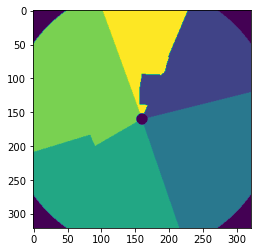

In [9]:
plt.imshow(NSIDC_PATH_nn)

In [10]:
NSIDC_PATH_nn.shape

(321, 321)

In [11]:
data_vars = {'Regions':(['x','y'],NSIDC_PATH_nn)}
ds = xr.Dataset(data_vars = data_vars,
                coords={'x_ease':(['x','y'],x_PATH),
                        'y_ease':(['x','y'],y_PATH)})
ds.to_netcdf(f'/Users/carmennab/Dropbox/michel_csao/regions_EASE.nc','w')

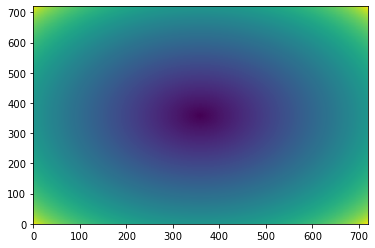

In [35]:
plt.pcolor(lat_grid)

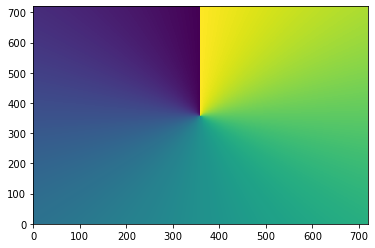

In [36]:
plt.pcolor(lon_grid)

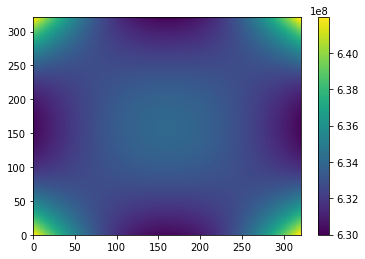

In [13]:
plt.pcolor(xdist*ydist)
plt.colorbar()
areaPathfinder=xdist*ydist

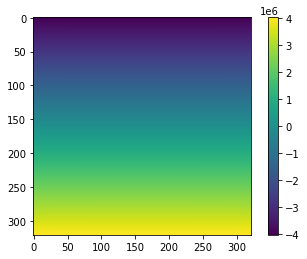

In [38]:
plt.imshow(x_PATH)
plt.colorbar()

### load and regrid SIC

In [109]:
filepath = '/Users/carmennab/Dropbox/michel_csao/ice_conc_sh_ease2-250_cdr-v3p0-amsr_201801311200.nc'
data = Dataset(filepath)

conc = np.array(data['ice_conc'])[0]

conc[conc>0.5] = np.nan
conc[conc<0] = 1
conc[conc<0.5] = np.nan

lon = np.array(data['lon'])
lat = np.array(data['lat'])

x_old, y_old = WGS84toEASE2(lon, lat)

conc_grid = griddata((x_old.ravel(), y_old.ravel()), conc.ravel(), (x_PATH, y_PATH), method='nearest')
conc_grid[y_PATH>3000000] = np.nan
conc_grid[x_PATH<-2500000] = np.nan

### plot figure 

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


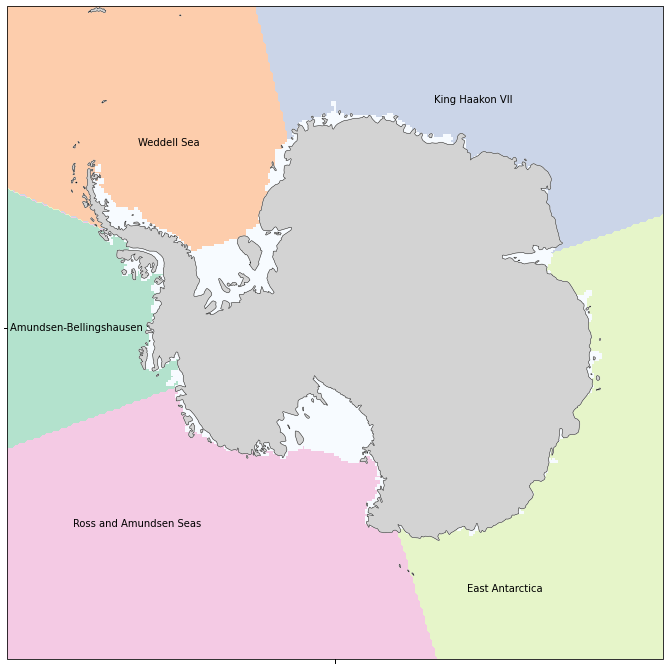

In [110]:
# All regions annotated

# Create the map for the mean advection
biasContDist = 0.5

ColorTable = np.array(['#b3e2cd','#fdcdac', '#cbd5e8', '#e6f5c9', '#f4cae4','#b3e2cd'])
iContNr = len(ColorTable)
iMinMax = 12. * biasContDist / 2. + biasContDist / 2.
clevsTD = np.arange(-iMinMax, iMinMax + 0.0001, biasContDist)

fig = plt.figure(figsize=(12, 12))

ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

nameregions=['Amundsen-Bellingshausen Sea','Weddell Sea','King Haakon VII','East Antarctica','Ross and Amundsen Seas','Ocean / higher latitude']

s = plt.contourf(x_PATH, y_PATH, NSIDC_PATH_nn, colors=ColorTable)
plt.xticks(ticks=range(len(nameregions)), labels=[])
plt.yticks(ticks=range(len(nameregions)), labels=[])

plt.text(0.005, 0.5, nameregions[0], ha='left', va='bottom', transform=ax.transAxes, fontsize=10)
plt.text(0.2, 0.8, nameregions[1], ha='left', va='top', transform=ax.transAxes, fontsize=10)
plt.text(0.65, 0.85, nameregions[2], ha='left', va='bottom', transform=ax.transAxes, fontsize=10)
plt.text(0.7, 0.1, nameregions[3], ha='left', va='bottom', transform=ax.transAxes, fontsize=10)
plt.text(0.1, 0.2, nameregions[4], ha='left', va='bottom', transform=ax.transAxes, fontsize=10)

ax.add_feature(cfeature.COASTLINE, zorder=100,linewidth=0.4)
ax.add_feature(cfeature.LAND, zorder=99, color='lightgray', edgecolor='black')
ax.pcolormesh(x_PATH, y_PATH, conc_grid, cmap='Blues')

# Save the main plot after displaying it
plt.savefig('/Users/carmennab/Dropbox/michel_csao/regions.png', dpi=300)